## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `11_delta_dce_categories` 
### Recreating the delta dce categories from Susan's R notebook

created by Cassie Lumbrazo\
last updated: Oct 2024\
run location: locally\
python environment: **rasterio_scalebar**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

# import csv 
# import copy 
# import os.path 

import geopandas as gpd
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
# import rasterio

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# Paths for local machine
ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') 

# Create the 6 categories 
* Category 1: where the forest pixel from 2021 became denser forest 2023 
* Category 2: where the forest pixel from 2021 turned into a forest edge in 2023 
* Category 3: where there was no change to the pixel classification 
* Category 4: where the open pixel from 2021 became less open in 2023 
* Category 5: where the open pixel from 2021 became more open in 2023 
* Category 6: where the forest pixel from 2021 became an open pixel in 2023

Otherwise known as, 

1: forest to denser forest

2: forest to edge

3: no change

4: open to less open

5: open to more open

6: forest to open


This code cell below is my first attempt at recreating the categories myself, without direct link to Susan's RCode

In [4]:
# # Calculate delta DCE
# delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# # Create a new variable to store the categories
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 1, 0)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] >= 0), 6, ds['delta_dce_cat'])
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] >= 0) & (delta_dce < 0), 4, ds['delta_dce_cat'])
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] >= 0) & (delta_dce > 0), 5, ds['delta_dce_cat'])
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 2, ds['delta_dce_cat'])
# ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

And, fixing some of the conditional statements to match the RCode Exactly.. and the order exactly that in the current Table DCE.  

Ordering:

1. Category 1: Most_Forested (ncalm negative, rapid negative, delta DCE negative) forest to denser forest 
2. Category 2: More_Forested (ncalm negative, rapid negative, delta DCE positive) forest to edge
3. Category 3: No_Change (delta DCE close to zero) no change
4. Category 4: Less_Open (ncalm positive, rapid less than ncalm) open to less open
5. Category 5: More_Open (ncalm positive, rapid greater than ncalm) open to more open
6. Category 6: Most_Open (ncalm negative, rapid positive) forest to open


In [5]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Most Forested (ncalm negative, rapid negative, delta DCE negative) forest to denser forest
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: More Forested (ncalm negative, rapid negative, delta DCE positive) forest to edge 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5)) no change 
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Less Open (ncalm positive, rapid less than ncalm) open to less open 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: More Open (ncalm positive, rapid greater than ncalm) open to more open 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Most Open (ncalm negative, rapid positive) forest to open 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

Now, we have our delta_dce categories but we also need to do the following, (paragraph from manuscript)

"The snow depth values for both years for the delta DCE category 3 (no change) were used to compute mean values of 0.37 and 0.40 m for 2021 and 2023, respectively, and standard deviations of 0.32 and 0.22. These values were used to normalize snow depth for all pixels in each year as the number of standard deviations away from the mean value."

In [6]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


These mean and standard deviation values are different than the ones Susan reported in the paper...

In [7]:
# # normalized ncalm snow depth by delta DCE category
# ds['hs_ncalm_normalized_delta_dce_cat_1'] = ds['hs_ncalm_normalized'].where(ds['delta_dce_cat'] == 1)
# ds['hs_ncalm_normalized_delta_dce_cat_2'] = ds['hs_ncalm_normalized'].where(ds['delta_dce_cat'] == 2)
# ds['hs_ncalm_normalized_delta_dce_cat_3'] = ds['hs_ncalm_normalized'].where(ds['delta_dce_cat'] == 3)
# ds['hs_ncalm_normalized_delta_dce_cat_4'] = ds['hs_ncalm_normalized'].where(ds['delta_dce_cat'] == 4)
# ds['hs_ncalm_normalized_delta_dce_cat_5'] = ds['hs_ncalm_normalized'].where(ds['delta_dce_cat'] == 5)
# ds['hs_ncalm_normalized_delta_dce_cat_6'] = ds['hs_ncalm_normalized'].where(ds['delta_dce_cat'] == 6)

# # normalized rapid snow depth by delta DCE category
# ds['hs_rapid_normalized_delta_dce_cat_1'] = ds['hs_rapid_normalized'].where(ds['delta_dce_cat'] == 1)
# ds['hs_rapid_normalized_delta_dce_cat_2'] = ds['hs_rapid_normalized'].where(ds['delta_dce_cat'] == 2)
# ds['hs_rapid_normalized_delta_dce_cat_3'] = ds['hs_rapid_normalized'].where(ds['delta_dce_cat'] == 3)
# ds['hs_rapid_normalized_delta_dce_cat_4'] = ds['hs_rapid_normalized'].where(ds['delta_dce_cat'] == 4)
# ds['hs_rapid_normalized_delta_dce_cat_5'] = ds['hs_rapid_normalized'].where(ds['delta_dce_cat'] == 5)
# ds['hs_rapid_normalized_delta_dce_cat_6'] = ds['hs_rapid_normalized'].where(ds['delta_dce_cat'] == 6)

Now, do the same for the difference in normalized snow depth between the two years, but also do it by aspect 

In [8]:
# difference in normalized snow depth by delta DCE category
ds['hs_diff_normalized_delta_dce_cat_1'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 1)
ds['hs_diff_normalized_delta_dce_cat_2'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 2)
ds['hs_diff_normalized_delta_dce_cat_3'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 3)
ds['hs_diff_normalized_delta_dce_cat_4'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 4)
ds['hs_diff_normalized_delta_dce_cat_5'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 5)
ds['hs_diff_normalized_delta_dce_cat_6'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 6)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_normalized_delta_dce_cat_1_s'] = ds['hs_diff_normalized_delta_dce_cat_1'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_2_s'] = ds['hs_diff_normalized_delta_dce_cat_2'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_3_s'] = ds['hs_diff_normalized_delta_dce_cat_3'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_4_s'] = ds['hs_diff_normalized_delta_dce_cat_4'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_5_s'] = ds['hs_diff_normalized_delta_dce_cat_5'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_6_s'] = ds['hs_diff_normalized_delta_dce_cat_6'].where(ds['baf_ridge'] ==  1)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_normalized_delta_dce_cat_1_n'] = ds['hs_diff_normalized_delta_dce_cat_1'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_2_n'] = ds['hs_diff_normalized_delta_dce_cat_2'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_3_n'] = ds['hs_diff_normalized_delta_dce_cat_3'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_4_n'] = ds['hs_diff_normalized_delta_dce_cat_4'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_5_n'] = ds['hs_diff_normalized_delta_dce_cat_5'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_6_n'] = ds['hs_diff_normalized_delta_dce_cat_6'].where(ds['baf_ridge'] == -1)

Now, it's plot this and take a look as CDFs

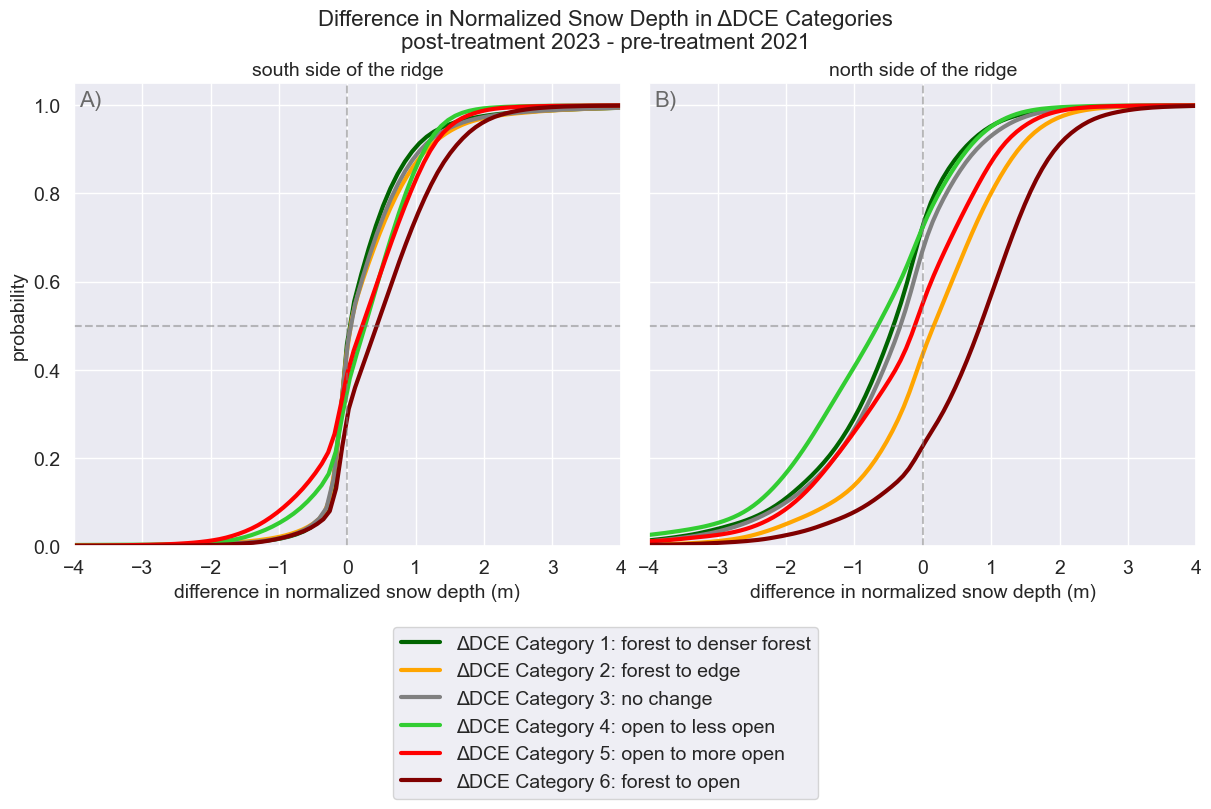

In [10]:
# plot of a histogram of all those variables 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6), constrained_layout = True)
alpha=0.7

# plots
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_s'].values.flatten(), ax=axes[0], color='darkgreen', label='ΔDCE Category 1: forest to denser forest', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_s'].values.flatten(), ax=axes[0], color='orange',    label='ΔDCE Category 2: forest to edge', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_s'].values.flatten(), ax=axes[0], color='grey',      label='ΔDCE Category 3: no change', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_s'].values.flatten(), ax=axes[0], color='limegreen',      label='ΔDCE Category 4: open to less open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_s'].values.flatten(), ax=axes[0], color='red',       label='ΔDCE Category 5: open to more open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_s'].values.flatten(), ax=axes[0], color='maroon',    label='ΔDCE Category 6: forest to open', cumulative=True, linewidth=3)

sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_n'].values.flatten(), ax=axes[1], color='darkgreen', label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_n'].values.flatten(), ax=axes[1], color='orange',    label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_n'].values.flatten(), ax=axes[1], color='grey',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_n'].values.flatten(), ax=axes[1], color='limegreen',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_n'].values.flatten(), ax=axes[1], color='red',       label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_n'].values.flatten(), ax=axes[1], color='maroon',    label=None, cumulative=True, linewidth=3)

# labels
fontsize_num = 14
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)
axes[1].set_title('north side of the ridge', fontsize=fontsize_num)

axes[0].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)
axes[1].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)

axes[0].set_ylabel('probability', fontsize=fontsize_num)
axes[1].set_ylabel('')

axes[0].set_xlim(-4,4)

plt.suptitle('Difference in Normalized Snow Depth in ΔDCE Categories\npost-treatment 2023 - pre-treatment 2021', fontsize=16)
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
fig.legend(bbox_to_anchor=(0.5,-0.18), loc='center', ncol=1, fontsize = fontsize_num)

# increase the size of tick marks 
axes[0].tick_params(axis='both', labelsize=fontsize_num)
axes[1].tick_params(axis='both', labelsize=fontsize_num)

# add an A), B) to the figure 
axes[0].text(0.01, 0.95, 'A)', fontsize=16, color='dimgray', transform=axes[0].transAxes)
axes[1].text(0.01, 0.95, 'B)', fontsize=16, color='dimgray', transform=axes[1].transAxes)

# add thin grey lines at 0.5 y axis and 0 x axis 
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)

plt.show()

Maybe blues or browns for categories that are ending open and greens for categories that end as forests?

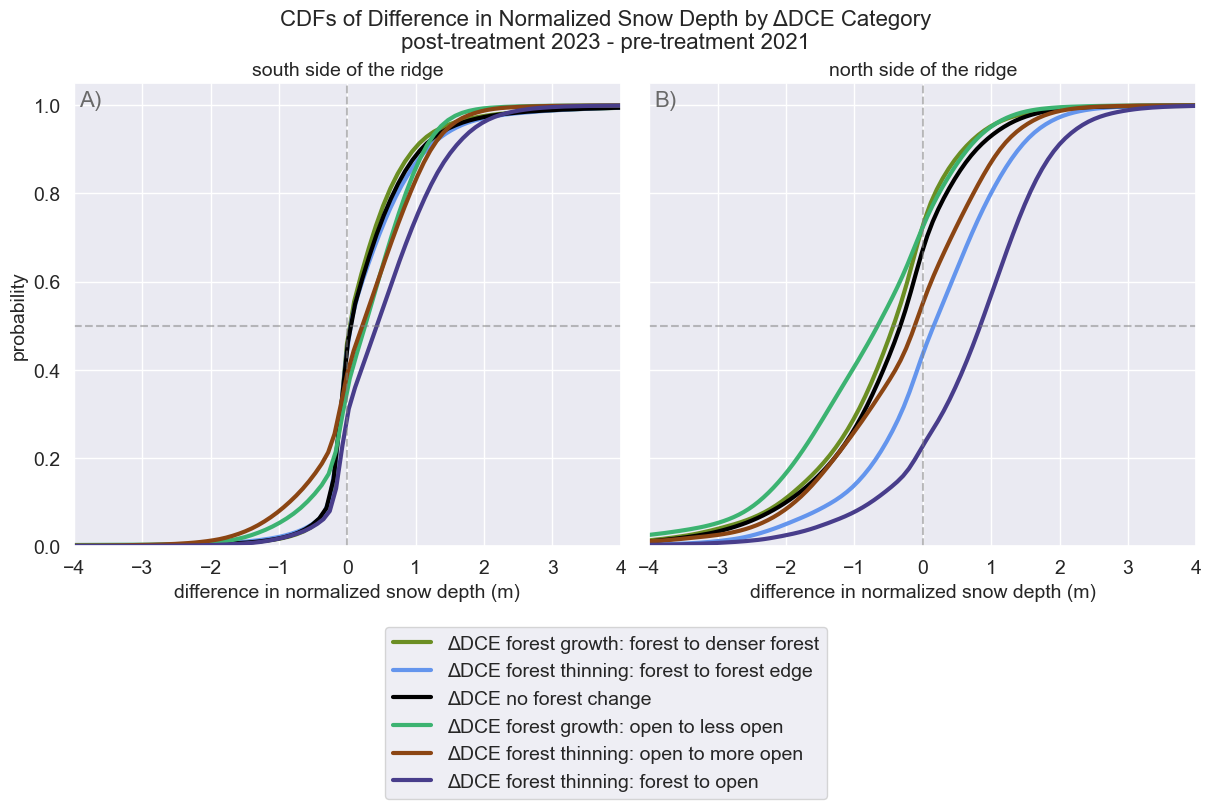

In [13]:
# plot of a histogram of all those variables 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6), constrained_layout = True)
alpha=0.7

# plots
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_s'].values.flatten(), ax=axes[0], color='olivedrab', label='ΔDCE forest growth: forest to denser forest', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_s'].values.flatten(), ax=axes[0], color='cornflowerblue',    label='ΔDCE forest thinning: forest to forest edge', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_s'].values.flatten(), ax=axes[0], color='black',      label='ΔDCE no forest change', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_s'].values.flatten(), ax=axes[0], color='mediumseagreen',      label='ΔDCE forest growth: open to less open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_s'].values.flatten(), ax=axes[0], color='saddlebrown',       label='ΔDCE forest thinning: open to more open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_s'].values.flatten(), ax=axes[0], color='darkslateblue',    label='ΔDCE forest thinning: forest to open', cumulative=True, linewidth=3)

sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_n'].values.flatten(), ax=axes[1], color='olivedrab', label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_n'].values.flatten(), ax=axes[1], color='cornflowerblue',    label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_n'].values.flatten(), ax=axes[1], color='black',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_n'].values.flatten(), ax=axes[1], color='mediumseagreen',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_n'].values.flatten(), ax=axes[1], color='saddlebrown',       label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_n'].values.flatten(), ax=axes[1], color='darkslateblue',    label=None, cumulative=True, linewidth=3)

# labels
fontsize_num = 14
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)
axes[1].set_title('north side of the ridge', fontsize=fontsize_num)

axes[0].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)
axes[1].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)

axes[0].set_ylabel('probability', fontsize=fontsize_num)
axes[1].set_ylabel('')

axes[0].set_xlim(-4,4)

plt.suptitle('CDFs of Difference in Normalized Snow Depth by ΔDCE Category\npost-treatment 2023 - pre-treatment 2021', fontsize=16)
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
fig.legend(bbox_to_anchor=(0.5,-0.18), loc='center', ncol=1, fontsize = fontsize_num)

# increase the size of tick marks 
axes[0].tick_params(axis='both', labelsize=fontsize_num)
axes[1].tick_params(axis='both', labelsize=fontsize_num)

# add an A), B) to the figure 
axes[0].text(0.01, 0.95, 'A)', fontsize=16, color='dimgray', transform=axes[0].transAxes)
axes[1].text(0.01, 0.95, 'B)', fontsize=16, color='dimgray', transform=axes[1].transAxes)

# add thin grey lines at 0.5 y axis and 0 x axis 
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)

plt.show()

### Now, plot the non-normalized difference in snow depth

In [12]:
ds['hs_diff'] = ds['hs_rapid'] - ds['hs_ncalm']

# difference in snow depth by delta DCE category
ds['hs_diff_delta_dce_cat_1'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 1)
ds['hs_diff_delta_dce_cat_2'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 2)
ds['hs_diff_delta_dce_cat_3'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 3)
ds['hs_diff_delta_dce_cat_4'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 4)
ds['hs_diff_delta_dce_cat_5'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 5)
ds['hs_diff_delta_dce_cat_6'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 6)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_delta_dce_cat_1_s'] = ds['hs_diff_delta_dce_cat_1'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_2_s'] = ds['hs_diff_delta_dce_cat_2'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_3_s'] = ds['hs_diff_delta_dce_cat_3'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_4_s'] = ds['hs_diff_delta_dce_cat_4'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_5_s'] = ds['hs_diff_delta_dce_cat_5'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_6_s'] = ds['hs_diff_delta_dce_cat_6'].where(ds['baf_ridge'] ==  1)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_delta_dce_cat_1_n'] = ds['hs_diff_delta_dce_cat_1'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_2_n'] = ds['hs_diff_delta_dce_cat_2'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_3_n'] = ds['hs_diff_delta_dce_cat_3'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_4_n'] = ds['hs_diff_delta_dce_cat_4'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_5_n'] = ds['hs_diff_delta_dce_cat_5'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_6_n'] = ds['hs_diff_delta_dce_cat_6'].where(ds['baf_ridge'] == -1)

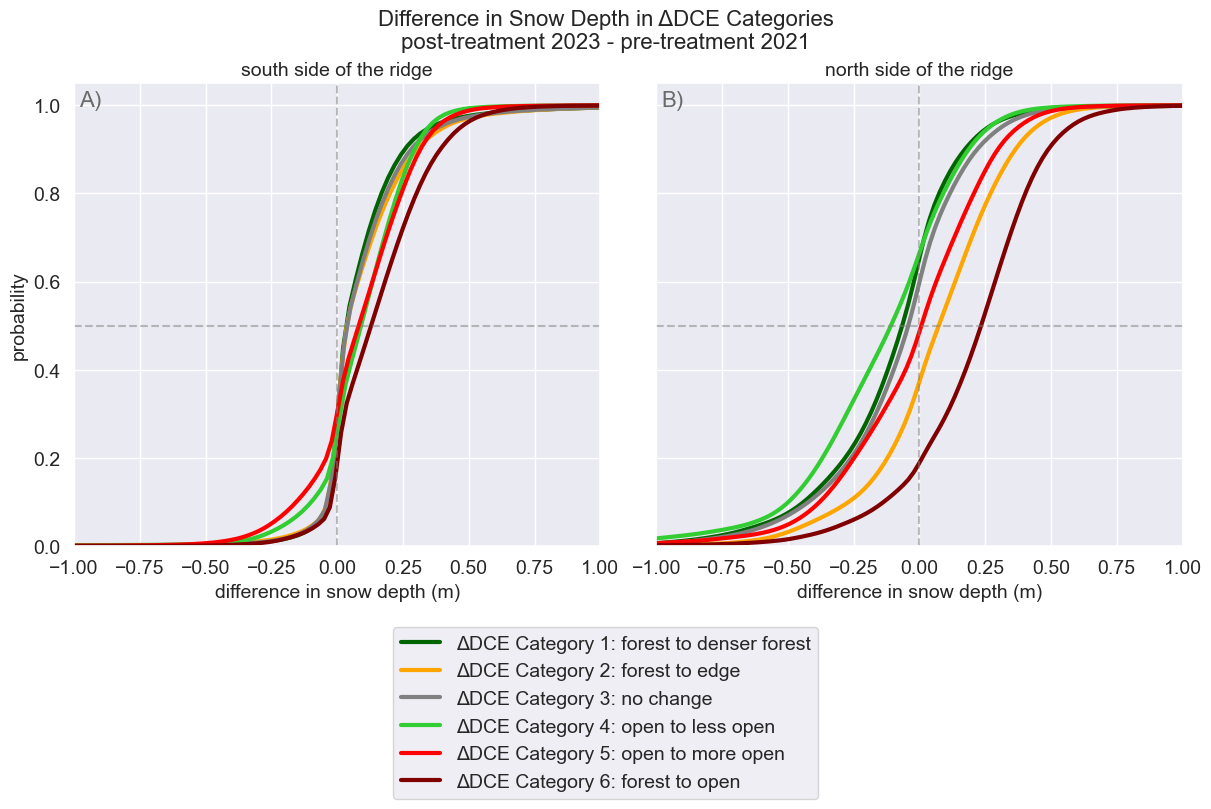

In [15]:
# plot of a histogram of all those variables 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6), constrained_layout = True)
alpha=0.7

# plots
sns.kdeplot(ds['hs_diff_delta_dce_cat_1_s'].values.flatten(), ax=axes[0], color='darkgreen', label='ΔDCE Category 1: forest to denser forest', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_2_s'].values.flatten(), ax=axes[0], color='orange',    label='ΔDCE Category 2: forest to edge', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_3_s'].values.flatten(), ax=axes[0], color='grey',      label='ΔDCE Category 3: no change', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_4_s'].values.flatten(), ax=axes[0], color='limegreen',      label='ΔDCE Category 4: open to less open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_5_s'].values.flatten(), ax=axes[0], color='red',       label='ΔDCE Category 5: open to more open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_6_s'].values.flatten(), ax=axes[0], color='maroon',    label='ΔDCE Category 6: forest to open', cumulative=True, linewidth=3)

sns.kdeplot(ds['hs_diff_delta_dce_cat_1_n'].values.flatten(), ax=axes[1], color='darkgreen', label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_2_n'].values.flatten(), ax=axes[1], color='orange',    label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_3_n'].values.flatten(), ax=axes[1], color='grey',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_4_n'].values.flatten(), ax=axes[1], color='limegreen',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_5_n'].values.flatten(), ax=axes[1], color='red',       label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_6_n'].values.flatten(), ax=axes[1], color='maroon',    label=None, cumulative=True, linewidth=3)

# labels
fontsize_num = 14
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)
axes[1].set_title('north side of the ridge', fontsize=fontsize_num)

axes[0].set_xlabel('difference in snow depth (m)', fontsize=fontsize_num)
axes[1].set_xlabel('difference in snow depth (m)', fontsize=fontsize_num)

axes[0].set_ylabel('probability', fontsize=fontsize_num)
axes[1].set_ylabel('')

axes[0].set_xlim(-1,1)

plt.suptitle('Difference in Snow Depth in ΔDCE Categories\npost-treatment 2023 - pre-treatment 2021', fontsize=16)
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
fig.legend(bbox_to_anchor=(0.5,-0.18), loc='center', ncol=1, fontsize = fontsize_num)

# increase the size of tick marks 
axes[0].tick_params(axis='both', labelsize=fontsize_num)
axes[1].tick_params(axis='both', labelsize=fontsize_num)

# add an A), B) to the figure 
axes[0].text(0.01, 0.95, 'A)', fontsize=16, color='dimgray', transform=axes[0].transAxes)
axes[1].text(0.01, 0.95, 'B)', fontsize=16, color='dimgray', transform=axes[1].transAxes)

# add thin grey lines at 0.5 y axis and 0 x axis 
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)

plt.show()